In [1]:
LOAD_MODEL = 'models/transformer.01.pt'
MODEL_CHECKPOINT = 'models/transformer.01.pt'
DATASET_PATH = 'data/interim/preprocessed_paranmt3.tsv'

In [2]:
import numpy as np

from torch.utils.data import DataLoader
import torch
import torch.nn as nn
from torch.optim import Adam

import os
os.chdir("..") # go to the root dir

## Get the Dataset

In [3]:
MAX_SENT_SIZE = 10
MAX_TOKENS = 25_000

In [4]:
from src.data.make_dataset import ParanmtDataset

train_dataset = ParanmtDataset(
    path=DATASET_PATH,
    max_sent_size=MAX_SENT_SIZE,
    train=True,
    seed=42,
)

In [5]:
train_dataset.build_vocab(
    min_freq=2,
    specials=['<unk>', '<pad>', '<sos>', '<eos>'],
    max_tokens=MAX_TOKENS,
)

In [6]:
enc_vocab = train_dataset.toxic_vocab
dec_vocab = train_dataset.neutral_vocab

In [7]:
print("size of encoder vocab:", len(enc_vocab))
print("size of decoder vocab:", len(dec_vocab))

size of encoder vocab: 12137
size of decoder vocab: 14544


In [8]:
val_dataset = ParanmtDataset(
    path=DATASET_PATH,
    max_sent_size=MAX_SENT_SIZE,
    vocabs=(enc_vocab, dec_vocab), # avoid data leakage
    train=False,
    seed=42,
    take_first=10_000,
)

In [9]:
len(train_dataset), len(val_dataset)

(162961, 10000)

## Let's create Dataloader

In [10]:
batch_size = 256

In [11]:
train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
)

val_dataloader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
)

In [12]:
# let's check if shape and everything is ok
for batch in train_dataloader:
    toxic_sent, neutral_sent = batch
    print("toxic_sent.shape:", toxic_sent.shape)
    print("neutral_sent.shape:", neutral_sent.shape)
    break

toxic_sent.shape: torch.Size([256, 10])
neutral_sent.shape: torch.Size([256, 10])


In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Load the Model

- Transformer architerture

In [14]:
from src.models.transformer.encoder import Encoder
from src.models.transformer.decoder import Decoder
from src.models.transformer import Transformer

In [15]:
# configure some parameters for the model
heads = 4
hidden_dim = 256
ff_expantion = 4
max_size = MAX_SENT_SIZE

## Encoder
enc_input_dim = len(enc_vocab)
enc_dropout = 0.1
enc_num_layers = 3
enc_padding_idx = enc_vocab['<pad>']

## Decoder
dec_output_dim = len(dec_vocab)
dec_dropout = 0.1
dec_num_layers = 3
dec_padding_idx = dec_vocab['<pad>']

In [16]:
# load the encoder and decoder for our model
encoder = Encoder(
    input_dim=enc_input_dim,
    hidden_dim=hidden_dim,
    num_layers=enc_num_layers,
    heads=heads,
    ff_expantion=ff_expantion,
    dropout=enc_dropout,
    device=device,
    max_size=max_size,
    vocab=enc_vocab,
).to(device)

decoder = Decoder(
    output_dim=dec_output_dim,
    hidden_dim=hidden_dim,
    num_layers=dec_num_layers,
    heads=heads,
    ff_expantion=ff_expantion,
    dropout=dec_dropout,
    device=device,
    max_size=max_size,
    vocab=dec_vocab,
).to(device)

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [17]:
best_loss = float('inf')

model = Transformer(
    encoder=encoder,
    decoder=decoder,
    device=device,
    max_sent_size=MAX_SENT_SIZE,
).to(device)

In [18]:
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
criterion = torch.nn.CrossEntropyLoss(ignore_index=decoder.padding_idx)

In [19]:
from src.models.train_model import train

best_loss = train(
    model=model,
    loaders=(train_dataloader, val_dataloader),
    optimizer=optimizer,
    criterion=criterion,
    epochs=10,
    device=device,
    best_loss=best_loss,
    ckpt_path=MODEL_CHECKPOINT,
)

Evaluating 10: 100%|██████████| 40/40 [00:00<00:00, 54.61it/s, loss=2.36]


In [20]:
# let's load the model and predict
model = torch.load(MODEL_CHECKPOINT)
model.to(device)
model.eval()
None

In [23]:
from nltk.tokenize.treebank import TreebankWordDetokenizer
detokenizer = TreebankWordDetokenizer()

# let's see how our model works
num_examples = 10
df = val_dataset
for _ in range(num_examples):
    idx = np.random.randint(0, len(df))
    toxic_sent = detokenizer.detokenize(df.df.loc[idx, 'toxic_sent'])
    neutral_sent = detokenizer.detokenize(df.df.loc[idx, 'neutral_sent'])

    print('toxic_sent:', toxic_sent)
    print('neutral_sent:', neutral_sent)
    print('prediction:', model.predict(toxic_sent, post_process_text=True))
    print("\n")

toxic_sent: what the hell are you talking about?
neutral_sent: what are you talking about?
prediction: what are you talking about?


toxic_sent: my jelly stole my act . liar!
neutral_sent: my jelly stole my output.
prediction: my face is lying.


toxic_sent: 1390? shit, this is impossible.
neutral_sent: hell, that is impossible.
prediction: , is this?


toxic_sent: some kind of goddamn hero?
neutral_sent: some kind of hero?
prediction: some kind of a hero?


toxic_sent: someone killed them.
neutral_sent: they were murdered.
prediction: someone killed them.


toxic_sent: the boy must be starved
neutral_sent: the boy must be hungry.
prediction: the boy must be boy.


toxic_sent: do not fucking get angry.
neutral_sent: then do not be mad.
prediction: do not get out of a.


toxic_sent: who the hell is that?
neutral_sent: who are these guys?
prediction: who is that?


toxic_sent: and this one is my grandma masturbating.
neutral_sent: and this is my grandmother.
prediction: and this is my si

## Let's visualize the attention weights

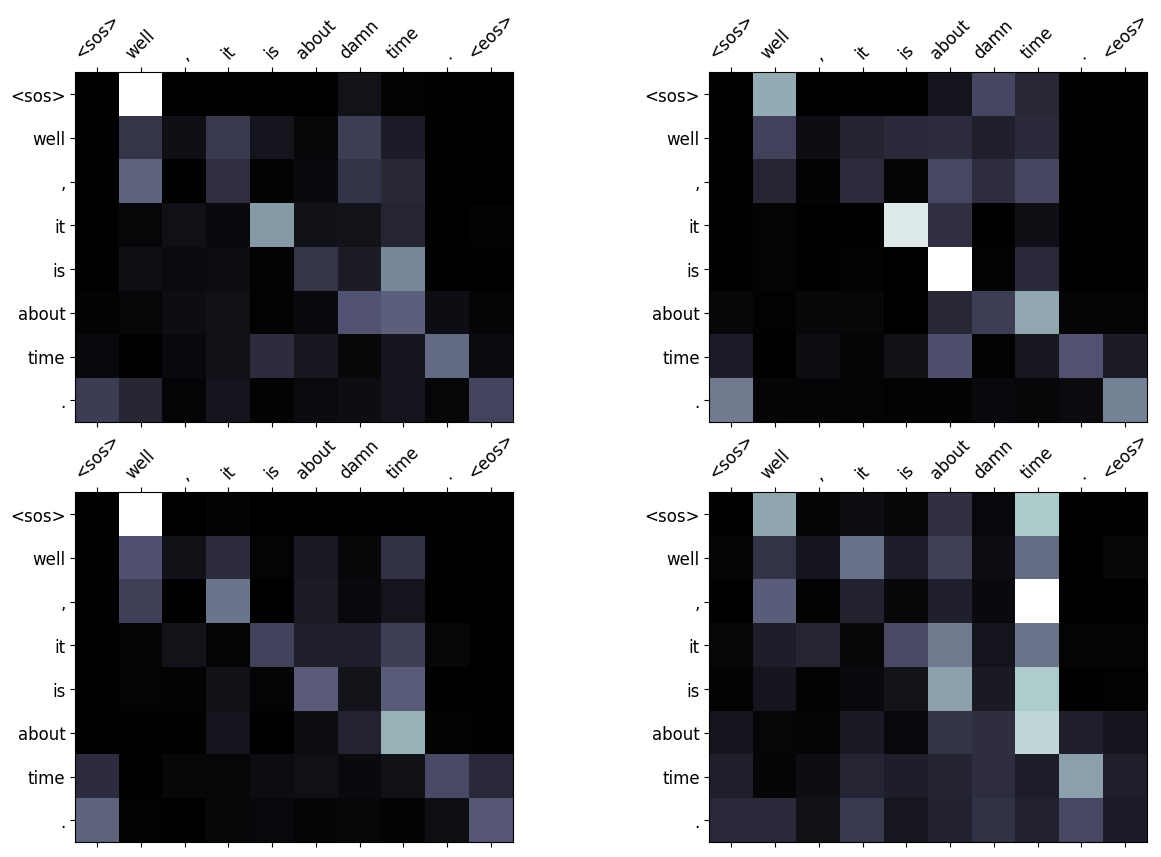

In [24]:
from src.visualization.visualize import display_attention

# let's take `idx`-th examle from val_dataset
idx = 6
src, trg = val_dataset[idx]
src = src.to(device).unsqueeze(0)
trg = trg.to(device).unsqueeze(0)
pred, attention = model.predict(src, return_attention=True, post_process_text=False)

src = src.cpu().detach().numpy()[0]
src = enc_vocab.lookup_tokens(src)
display_attention(src, pred, attention, n_heads=4, n_rows=2, n_cols=2)